

# Function to convert image and label to tf.train.Example
def image_example(image_string, label):
    feature = {
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Directory structure
base_dir = "data/train"  # Replace with the path to your dataset if different
class_folders = os.listdir(base_dir)

# Create TFRecord Writer
with tf.io.TFRecordWriter("data/train.tfrecord") as writer:
    # Iterate over class folders
    for label, folder_name in enumerate(class_folders):
        folder_path = os.path.join(base_dir, folder_name)
        # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Iterate over images in class folder
            for filename in os.listdir(folder_path):
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    filepath = os.path.join(folder_path, filename)
                    image_string = open(filepath, 'rb').read()
                    tf_example = image_example(image_string, label)
                    writer.write(tf_example.SerializeToString())


def _parse_function(proto):
    # Define the description of features
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    parsed_features['image'] = tf.io.decode_jpeg(parsed_features['image'])
    return parsed_features['image'], parsed_features['label']



In [1]:
import tensorflow as tf
import os

def load_dataset(tfrecord_file):
    dataset = tf.data.TFRecordDataset(filenames=[tfrecord_file])
    dataset = dataset.map(_parse_function)
    return dataset

def _parse_function(proto):
    feature_description = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image = tf.io.decode_jpeg(parsed_features['image'])
    
    # Preprocess the image: resize and normalize to [-1, 1]
    image = tf.image.resize(image, [224, 224])
    image = (image / 127.5) - 1
    
    # One-hot encode the labels
    label = tf.one_hot(parsed_features['label'], depth=38)  # Assuming 38 classes
    
    return image, label


In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_model(input_shape=(224, 224, 3)):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[:]:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2())(x)
    predictions = Dense(38, activation='softmax')(x)
    
    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model with specified optimizer and loss
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build the model
model = build_model()
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [3]:
dataset = load_dataset('data/train.tfrecord')
dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.batch(1)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

valDataset = load_dataset('data/valid.tfrecord')
valDataset = dataset.shuffle(buffer_size=10000)
valDataset = dataset.batch(1)
valDataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [4]:
# Build and compile the model
model = build_model()

# Train the model
history = model.fit(dataset, epochs=50, validation_data=valDataset)

Epoch 1/50
2447/2447 [==============================] - 85s 32ms/step - loss: 12.7359 - accuracy: 0.8974 - val_loss: 11.1399 - val_accuracy: 0.9620
Epoch 2/50
2447/2447 [==============================] - 77s 31ms/step - loss: 9.6994 - accuracy: 0.9722 - val_loss: 8.3085 - val_accuracy: 0.9743
Epoch 3/50
2447/2447 [==============================] - 78s 32ms/step - loss: 7.0778 - accuracy: 0.9837 - val_loss: 5.9493 - val_accuracy: 0.9877
Epoch 4/50
2447/2447 [==============================] - 87s 35ms/step - loss: 5.0513 - accuracy: 0.9886 - val_loss: 4.2404 - val_accuracy: 0.9943
Epoch 5/50
2447/2447 [==============================] - 78s 32ms/step - loss: 3.6399 - accuracy: 0.9918 - val_loss: 3.0911 - val_accuracy: 0.9980
Epoch 6/50
2447/2447 [==============================] - 79s 32ms/step - loss: 2.6505 - accuracy: 0.9922 - val_loss: 2.2525 - val_accuracy: 0.9955
Epoch 7/50
2447/2447 [==============================] - 84s 34ms/step - loss: 1.9560 - accuracy: 0.9947 - val_loss: 1.6804

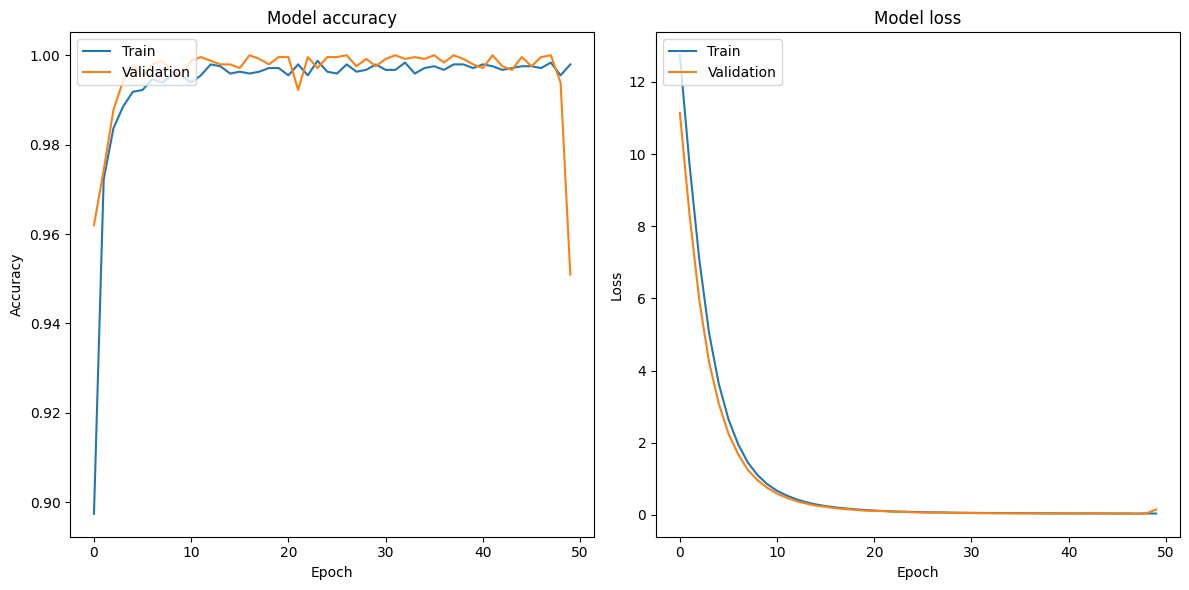

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import f1_score
import numpy as np
import tensorflow as tf

# Store all the true labels and predictions
y_true = []
y_pred = []

for images, labels in valDataset:
    predictions = model.predict(images)
    
    # Convert softmax output to label indices
    predictions = np.argmax(predictions, axis=1)
    
    # If labels are one-hot encoded, convert them to label indices
    labels = np.argmax(labels.numpy(), axis=1)
    
    y_true.extend(labels)
    y_pred.extend(predictions)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score: {f1}")


1/1 [==============================] - 0s 36ms/step
F1 Score: 0.9988807163415414


In [23]:
model.save('20231002_Model_tfRecords.h5')

In [24]:
loaded_model = tf.keras.models.load_model('20231002_Model_tfRecords.h5')